- Crear una señal de datos
- Separar la señal por pares de bits
- Codificar la señal

# Codificar En Huffman

In [358]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import square
from collections import Counter
import heapq
from itertools import count

class _Node:
    __slots__ = ("freq", "char", "left", "right")
    def __init__(self, freq, char=None, left=None, right=None):
        self.freq = freq
        self.char = char
        self.left = left
        self.right = right

def _build_huffman_tree(message: str) -> _Node:
    """
    Construye el árbol de Huffman para el mensaje.
    Maneja el caso borde de un único símbolo en el mensaje.
    """
    if not message:
        raise ValueError("El mensaje no puede ser vacío.")

    freq = Counter(message)
    pq, tie = [], count() # generador de orden para desempates
    for ch, f in freq.items(): 
        # (frecuencia, orden, nodo)
        heapq.heappush(pq, (f, next(tie), _Node(f, char=ch))) 

    # Caso especial: solo un símbolo -> crea un árbol con un hijo
    if len(pq) == 1:
        f, _, node = heapq.heappop(pq)
        root = _Node(f, left=node, right=None)
        return root

    while len(pq) > 1:
        f1, _, n1 = heapq.heappop(pq)
        f2, _, n2 = heapq.heappop(pq)
        parent = _Node(f1 + f2, left=n1, right=n2)
        heapq.heappush(pq, (parent.freq, next(tie), parent))

    return heapq.heappop(pq)[2]

def _build_codes(root: _Node) -> dict:
    """
    Recorre el árbol y genera el diccionario {caracter: código_en_bits}.
    """
    codes = {}

    def dfs(node, path):
        if node.char is not None:          # hoja
            codes[node.char] = path or "0" # si hay un solo símbolo, asígnale "0"
            return
        if node.left:
            dfs(node.left, path + "0")
        if node.right:
            dfs(node.right, path + "1")

    dfs(root, "")
    return codes

def huffman_encode(message: str):
    """
    Codifica `message` con Huffman.
    Returns:
        bits: str  -> secuencia de '0' y '1'
        codes: dict -> mapa {caracter: código}
    """
    root = _build_huffman_tree(message)
    codes = _build_codes(root)
    bits = "".join(codes[ch] for ch in message)
    return bits, codes

def huffman_decode(bits: str, codes: dict) -> str:
    """
    Decodifica la secuencia de bits usando el diccionario de códigos.
    """
    if not bits and codes:
        return ""  # nada que decodificar

    inv = {code: ch for ch, code in codes.items()}

    out = []
    acc = ""
    for b in bits:
        acc += b
        if acc in inv:
            out.append(inv[acc])
            acc = ""
    if acc:
        raise ValueError("Bits sobrantes: el flujo de bits no coincide con los códigos.")
    return "".join(out)

msg = "Hola"
print(len(msg)*8)
bits, codes = huffman_encode(msg)
print("Bits:", bits)
print("Códigos:", codes)
print(len(bits))
print("Decodificado:", huffman_decode(bits[:len(bits)], codes))
# Agregar 3 bits adificonales en 1 para evitar errores en la decodificacion
bits += '11'



32
Bits: 00011011
Códigos: {'H': '00', 'o': '01', 'l': '10', 'a': '11'}
8
Decodificado: Hola


# Creacion de Mensaje

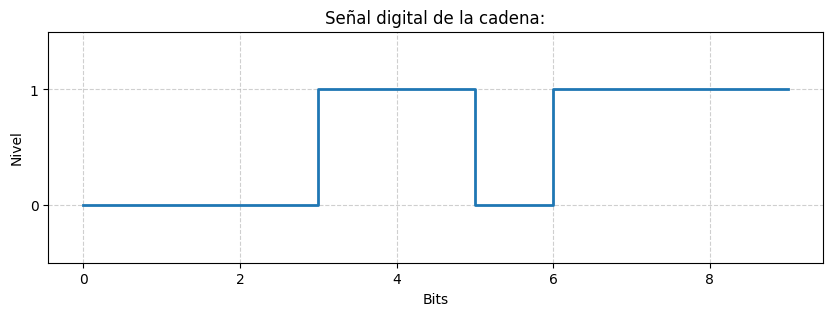

In [359]:

def graficar_bits(bits):
    # Crear 100 muestras por bit y al final unirlas
    for b in bits:
        if b == '0':
            segmento = np.zeros(1)
        else:
            segmento = np.ones(1)
        if 'y' in locals():
            y = np.concatenate((y, segmento))
        else:
            y = segmento
    # Crear la forma escalonada
    t=np.arange(0, len(bits)*1)  # Tiempo en ms
    plt.figure(figsize=(10, 3))
    plt.step(t, y, where='post', linewidth=2)
    plt.ylim(-0.5, 1.5)
    plt.yticks([0, 1])
    plt.xlabel('Bits')
    plt.ylabel('Nivel')
    plt.title(f'Señal digital de la cadena:')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.show()
    return t, y

# Ejemplo de uso
cadena = bits
t, señal=graficar_bits(cadena)
longitud_señal = len(señal)


# Creacion del Simbolo

['00', '01', '10', '11', '11']


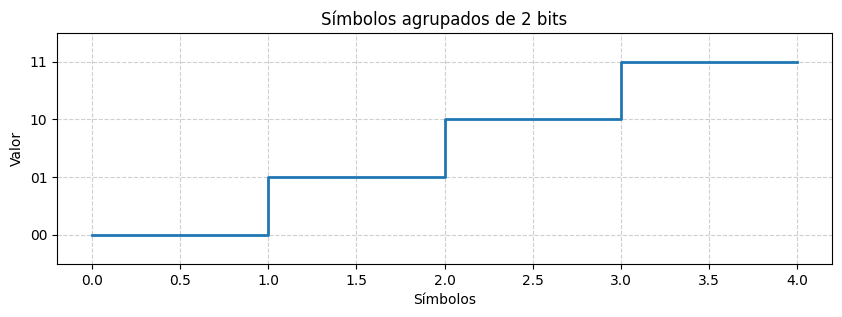

[(-1, -1), (-1, 1), (1, -1), (1, 1), (1, 1)]


In [360]:
# Agrupar de a dos en dos bits sabiendo que la señal cambia cada 50/len(cadena) muestras a partir de la señal generada anteriormente
def agrupar_bits(señal, duracion_bit, num_bits=2):
    simbolos = []
    muestras_por_simbolo = duracion_bit * num_bits
    for i in range(0, len(señal), muestras_por_simbolo):
        bits_simbolo = ''
        for j in range(num_bits):
            inicio = i + j * duracion_bit
            fin = inicio + duracion_bit
            if fin <= len(señal):
                bit = '1' if np.mean(señal[inicio:fin]) > 0.5 else '0'
                bits_simbolo += bit
        if len(bits_simbolo) == num_bits:
            simbolos.append(bits_simbolo)
    return simbolos
simbolos = agrupar_bits(señal, duracion_bit=1, num_bits=2)
print(simbolos)
# Graficar los simbolos agrupados
def graficar_simbolos(simbolos):
    plt.figure(figsize=(10, 3))
    plt.step(range(len(simbolos)), [int(s, 2) for s in simbolos], where='post', linewidth=2)
    plt.ylim(-0.5, 3.5)
    plt.yticks(range(4), ['00', '01', '10', '11'])
    plt.xlabel('Símbolos')
    plt.ylabel('Valor')
    plt.title('Símbolos agrupados de 2 bits')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.show()
graficar_simbolos(simbolos)
# mapear los simbolos a 4QAM
def mapear_4QAM(simbolos):
    mapping = {
        '00': (-1, -1),
        '01': (-1, 1),
        '10': (1, -1),
        '11': (1, 1)
    }
    señales_4QAM = [mapping[s] for s in simbolos]
    return señales_4QAM
señales_4QAM = mapear_4QAM(simbolos)
print(señales_4QAM)


# Crear Portadora a 4.8Mhz

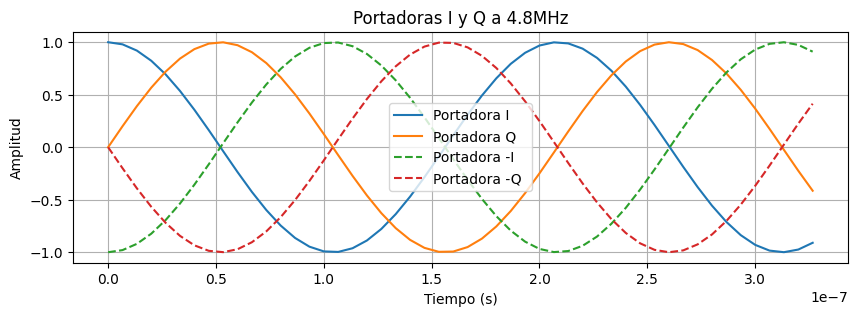

0.00020833333333333335


In [361]:
# crear portadora de 4Mhz y sus desfases
fs = 150000000  # frecuencia de muestreo 1MHz
fc = 4800000  # frecuencia de la portadora 4MHz
# Calcular compensacion de fase para la modulacion se de en fase 0 en el inicio de la señal
compensacion = 0
t_portadora = np.arange(0, len(t)/48000, 1/fs)
portadora_I = np.cos(2 * np.pi * fc * t_portadora+ compensacion)
portadora_Q = np.sin(2 * np.pi * fc * t_portadora+ compensacion)
portadora_Minus_I = np.cos(2 * np.pi * fc * t_portadora+ np.pi + compensacion)
portadora_Minus_Q = np.sin(2 * np.pi * fc * t_portadora+ np.pi + compensacion)
# Graficar portadoras
plt.figure(figsize=(10, 3))
plt.plot(t_portadora[:50], portadora_I[:50], label='Portadora I ')
plt.plot(t_portadora[:50], portadora_Q[:50], label='Portadora Q ')
plt.plot(t_portadora[:50], portadora_Minus_I[:50], label='Portadora -I ', linestyle='--')
plt.plot(t_portadora[:50], portadora_Minus_Q[:50], label='Portadora -Q ', linestyle='--')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Portadoras I y Q a 4.8MHz')
plt.legend()
plt.grid(True)
plt.show()
# Imprimir longitud de t_portadora en segundos
print(len(t_portadora)/ fs) 

# Selector de portadora

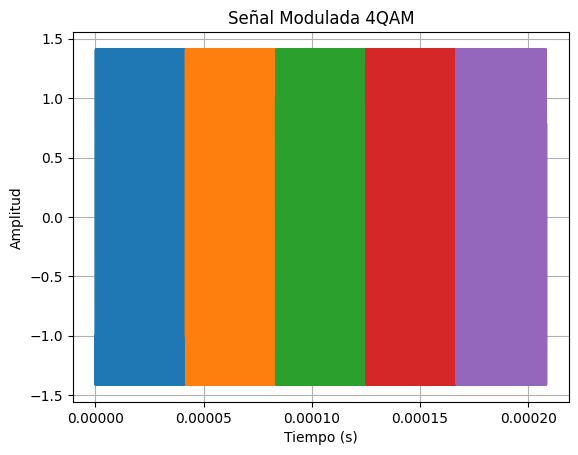

In [362]:
# Seleccionar la portadora según el símbolo 4QAM
def modular_4QAM(señales_4QAM, t_portadora, portadora_I, portadora_Q, portadora_Minus_I, portadora_Minus_Q):
    señal_modulada = np.zeros(len(t_portadora))
    muestras_por_simbolo = int(len(t_portadora) / len(señales_4QAM))
    for i, (I, Q) in enumerate(señales_4QAM):
        start = i * muestras_por_simbolo
        end = start + muestras_por_simbolo
        if I == 1 and Q == 1:
            señal_modulada[start:end] = portadora_I[start:end]+portadora_Q[start:end]
        elif I == 1 and Q == -1:
            señal_modulada[start:end] = portadora_Minus_Q[start:end]+portadora_I[start:end]
        elif I == -1 and Q == 1:
            señal_modulada[start:end] = portadora_Minus_I[start:end]+portadora_Q[start:end]
        elif I == -1 and Q == -1:
            señal_modulada[start:end] = portadora_Minus_Q[start:end]+portadora_Minus_I[start:end]
    return señal_modulada
señal_4QAM = modular_4QAM(señales_4QAM, t_portadora, portadora_I, portadora_Q, portadora_Minus_I, portadora_Minus_Q)
# Graficar señal modulada 4QAM

# Graficar todos los cambios de fase
for i in range(len(señales_4QAM)-1):
    start = (i+1) * int(len(t_portadora) / len(señales_4QAM))
    #plt.figure(figsize=(10, 3))
    #plt.plot(t_portadora[start-50:start+50], señal_4QAM[start-50:start+50], label=f'Cambio de símbolo {señales_4QAM[i]} a {señales_4QAM[i+1]}')
    if(False):
        if señales_4QAM[i] == (1, 1):
            plt.plot(t_portadora[start-50:start+50], (portadora_I+portadora_Q)[start-50:start+50], label='Portadora I,Q ', alpha=0.5)
            #plt.plot(t_portadora[start-50:start+50], portadora_Q[start-50:start+50], label='Portadora Q ')
        elif señales_4QAM[i] == (1, -1):
            plt.plot(t_portadora[start-50:start+50], (portadora_I+portadora_Minus_Q)[start-50:start+50], label='Portadora I,-Q ', alpha=0.5)
            #plt.plot(t_portadora[start-50:start+50], portadora_Minus_Q[start-50:start+50], label='Portadora -Q ')
        elif señales_4QAM[i] == (-1, 1):
            plt.plot(t_portadora[start-50:start+50], (portadora_Minus_I+portadora_Q)[start-50:start+50], label='Portadora -I,Q ', alpha=0.5)
            #plt.plot(t_portadora[start-50:start+50], portadora_Q[start-50:start+50], label='Portadora Q ')
        elif señales_4QAM[i] == (-1, -1):
            plt.plot(t_portadora[start-50:start+50], (portadora_Minus_I+portadora_Minus_Q)[start-50:start+50], label='Portadora -I,-Q ', alpha=0.5)
            #plt.plot(t_portadora[start-50:start+50], portadora_Minus_Q[start-50:start+50], label='Portadora -Q ')
    if(False):
        if señales_4QAM[i+1] == (1, 1):
            plt.plot(t_portadora[start-50:start+50], (portadora_I+portadora_Q)[start-50:start+50], label='Portadora I,Q ', alpha=0.5)
            #plt.plot(t_portadora[start-50:start+50], portadora_Q[start-50:start+50], label='Portadora Q ')
        elif señales_4QAM[i+1] == (1, -1):
            plt.plot(t_portadora[start-50:start+50], (portadora_I+portadora_Minus_Q)[start-50:start+50], label='Portadora I,-Q ', alpha=0.5)
            #plt.plot(t_portadora[start-50:start+50], portadora_Minus_Q[start-50:start+50], label='Portadora -Q ')
        elif señales_4QAM[i+1] == (-1, 1):
            plt.plot(t_portadora[start-50:start+50], (portadora_Minus_I+portadora_Q)[start-50:start+50], label='Portadora -I,Q ', alpha=0.5)
            #plt.plot(t_portadora[start-50:start+50], portadora_Q[start-50:start+50], label='Portadora Q ')
        elif señales_4QAM[i+1] == (-1, -1):
            plt.plot(t_portadora[start-50:start+50], (portadora_Minus_I+portadora_Minus_Q)[start-50:start+50], label='Portadora -I,-Q ', alpha=0.5)
            #plt.plot(t_portadora[start-50:start+50], portadora_Minus_Q[start-50:start+50], label='Portadora -Q ')
        
    #plt.title('Cambio de fase en señal 4QAM'+f' de {señales_4QAM[i]} a {señales_4QAM[i+1]}')
    #plt.legend()
    #plt.show()
plt.figure()
for i in range(len(señales_4QAM)):
    start = i * int(len(t_portadora) / len(señales_4QAM))
    end = start + int(len(t_portadora) / len(señales_4QAM))
    plt.plot(t_portadora[start:end], señal_4QAM[start:end], label=f'Símbolo {señales_4QAM[i]}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Modulada 4QAM')
#plt.legend()
plt.grid(True)
plt.show()


# Crear Canal

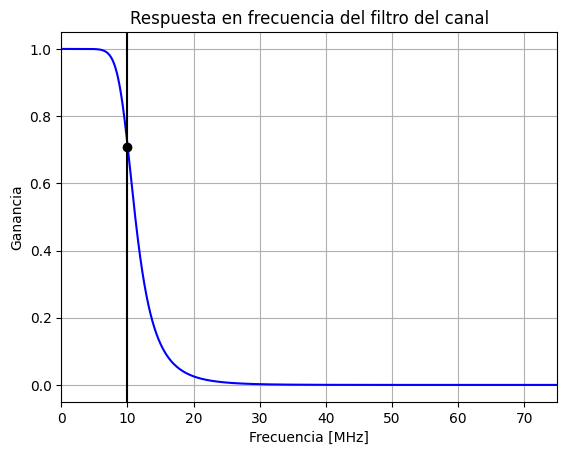

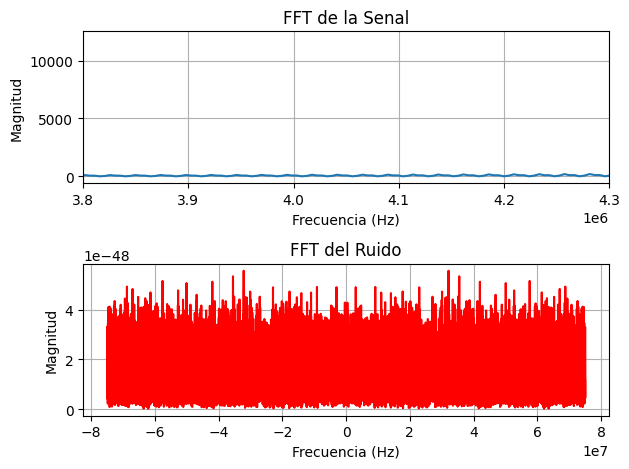

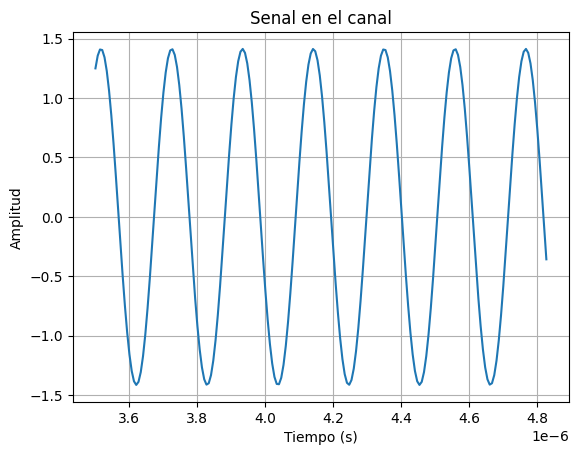

In [363]:
# Se debe simular un canal que contenga un LPF, atenuacion y ruido gaussiano
### Creacion del canal
import numpy
from scipy.signal import lfilter, freqz
from scipy.signal import lfilter
def aplicar_fft(x, fs):
    N = len(x)
    X = numpy.fft.fft(x)
    X = numpy.fft.fftshift(X)  # centrar la FFT
    f = numpy.fft.fftfreq(N, 1/fs)
    f = numpy.fft.fftshift(f)  # centrar las frecuencias
    return f, X
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
def crear_canal(x, fs, fc, atenuacion_db, snr_db=20):
    # Filtro LTF
    b, a = filtro_LTF(fc, fs)
    # Simular respuesta natural del filtro del canal
    w, h = freqz(b, a, worN=100*32000)
    plt.figure()
    plt.plot((0.16*fs*numpy.pi*w/numpy.pi)/1e6, numpy.abs(h), 'b')
    plt.plot(fc/1e6, 0.5*numpy.sqrt(2), 'ko')
    plt.axvline(fc/1e6, color='k')
    plt.xlim(0, 0.5*fs/1e6)
    plt.title("Respuesta en frecuencia del filtro del canal")
    plt.xlabel('Frecuencia [MHz]')
    plt.ylabel('Ganancia')
    plt.grid()
    plt.show()

    x_filtrada = aplicar_filtro(x, b, a)
    # Atenuacion
    x_ruidos = agregar_ruido_gaussiano(x_filtrada, snr_db)  # SNR de 20 dB
    atenuacion = 10 ** (atenuacion_db / 20)
    X_atenuada = x_ruidos * atenuacion

    return X_atenuada
# Adicion de ruido gaussiano
def agregar_ruido_gaussiano(x, snr_db):
    # Calcular potencia de la señal
    potencia_senal = numpy.mean(x**2)
    # Calcular potencia del ruido
    snr = 10 ** (snr_db / 10)
    potencia_ruido = potencia_senal / snr
    # Generar ruido gaussiano hasta 800 Mhz
    ruido = numpy.random.normal(0, numpy.sqrt(potencia_ruido), len(x))
    # Señal con ruido
    x_ruidosa = x + ruido
    #Graficacion FFT del Ruido
    f, X = aplicar_fft(x_ruidosa, fs)
    f_ruido, R = aplicar_fft(ruido, fs)
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(f, numpy.abs(X), label='Senal')
    plt.title('FFT de la Senal')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    #plt.ylim(0, 500)
    plt.xlim(3.8e6, 4.3e6)
    plt.grid()  
    plt.subplot(2,1,2)
    plt.plot(f_ruido, numpy.abs(R), label='Ruido', color='red')
    plt.title('FFT del Ruido')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.grid()  
    plt.tight_layout()
    plt.show()
    return x_ruidosa
# Prueba de canal
fcorte = 10e6
#aplicar el canal a la señal con codificacion unipolar
x_canal = crear_canal(señal_4QAM, fs, fcorte, atenuacion_db= 0 , snr_db=1000)
t_canal = t_portadora
plt.figure()
longitud=int(len(t)/50)
tempo=625

primer = int(longitud/2)+tempo
plt.plot(t_canal[primer-100:primer+100],x_canal[primer-100:primer+100], label='Senal en el canal')
plt.title('Senal en el canal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()


# Crear Detector de fase del canal

Fase estimada (radianes): 0.7408144600789344


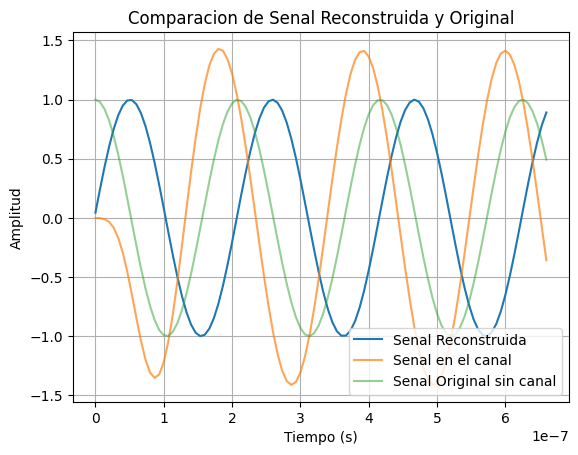

In [364]:
def estimar_fase(signal):
    # Calcular la transformada de Fourier de la señal
    fft_signal = numpy.fft.fft(signal)
    # Obtener el índice de la frecuencia fundamental (mayor magnitud)
    fundamental_index = numpy.argmax(numpy.abs(fft_signal))
    # Calcular la fase en radianes
    phase = numpy.angle(fft_signal[fundamental_index])
    return phase
# Detectar fase de la señal de los primeros 4 ciclos
fase_estimada = estimar_fase(x_canal[0:fs//fc*2])
print("Fase estimada (radianes):", fase_estimada)
# Generar señal cosenoidal con fase estimada

x_reconstruida = np.cos(2 * np.pi * fc * t_portadora -np.pi/4- fase_estimada)
t_reconstruida = t_portadora
# Comparar con la señal original
plt.figure()
plt.plot(t_reconstruida[0:100], x_reconstruida[0:100], label='Senal Reconstruida')
plt.plot(t_reconstruida[0:100], x_canal[0:100], label='Senal en el canal', alpha=0.7)
plt.plot(t_reconstruida[0:100], portadora_I[0:100], label='Senal Original sin canal', alpha=0.5)
plt.title('Comparacion de Senal Reconstruida y Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

Q_desfasada =np.cos(2 * np.pi * fc * t_portadora -np.pi/4- fase_estimada)
I_desfasada =np.sin(2 * np.pi * fc * t_portadora -np.pi/4- fase_estimada)


# Demodulacion

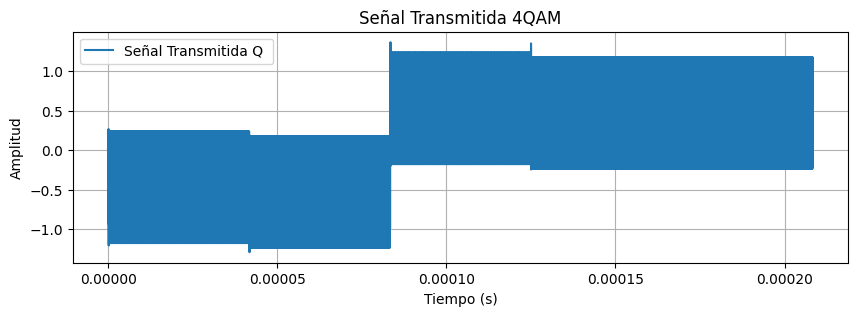

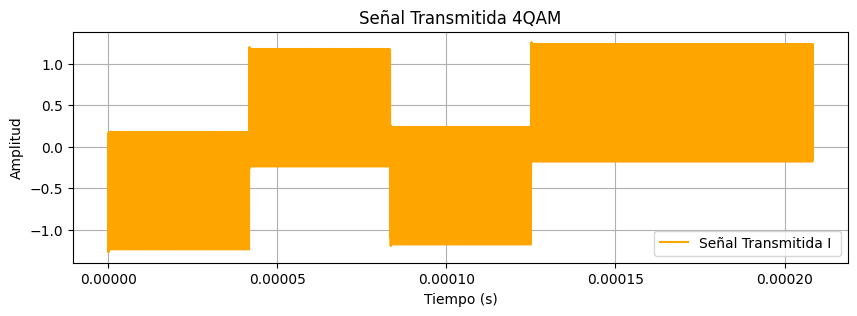

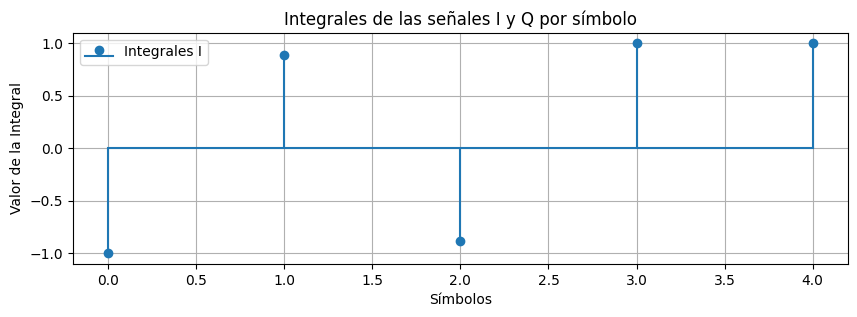

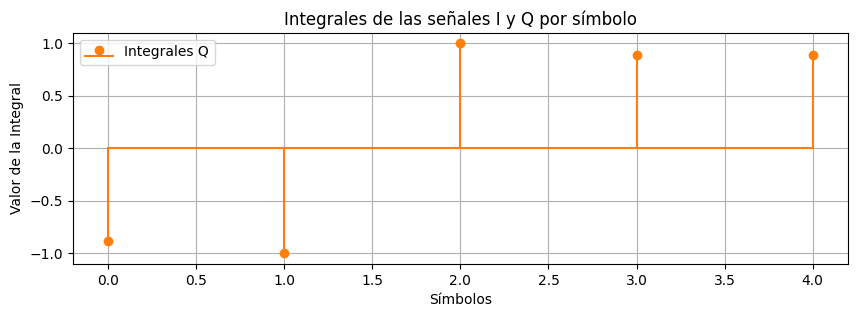

In [365]:
# Multiplicar la señal modulada por 4QAM por una de 4MHz para simular la transmisión
Pre_Filtro_I = x_canal* I_desfasada  # Simulación de la transmisión
Pre_Filtro_Q = x_canal * Q_desfasada  # Simulación de la transmisión
plt.figure(figsize=(10, 3))

plt.plot(t_portadora, Pre_Filtro_Q, label='Señal Transmitida Q ')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Transmitida 4QAM')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 3))
plt.plot(t_portadora, Pre_Filtro_I, label='Señal Transmitida I ', color='orange')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Transmitida 4QAM')
plt.legend()
plt.grid(True)
plt.show()

# Integrar cada señal desde 0 hasta la duración de cada símbolo
duracion_simbolo = int(len(t_portadora) / len(señales_4QAM))
integral_I = []
for i in range(len(señales_4QAM)):
    start = i * duracion_simbolo
    end = start + duracion_simbolo
    integral = np.trapezoid(Pre_Filtro_I[start:end], dx=1/fs)
    integral_I.append(integral)
integral_Q = []
for i in range(len(señales_4QAM)):
    start = i * duracion_simbolo
    end = start + duracion_simbolo
    integral = np.trapezoid(Pre_Filtro_Q[start:end], dx=1/fs)
    integral_Q.append(integral)
# Normalizar a 1 -1
max_I = max(abs(min(integral_I)), abs(max(integral_I)))
integral_I = [i / max_I for i in integral_I]
max_Q = max(abs(min(integral_Q)), abs(max(integral_Q)))
integral_Q = [i / max_Q for i in integral_Q]
# Graficar las integrales obtenidas
plt.figure(figsize=(10, 3))
plt.stem(range(len(integral_I)), integral_I, linefmt='C0-', markerfmt='C0o', basefmt='C0-', label='Integrales I')

plt.xlabel('Símbolos')
plt.ylabel('Valor de la Integral')
plt.title('Integrales de las señales I y Q por símbolo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.stem(range(len(integral_Q)), integral_Q, linefmt='C1-', markerfmt='C1o', basefmt='C1-', label='Integrales Q')
plt.xlabel('Símbolos')
plt.ylabel('Valor de la Integral')
plt.title('Integrales de las señales I y Q por símbolo')
plt.legend()
plt.grid(True)
plt.show()


# Crear Decodificacion

Bits Decodificados: 001001111
Bits Originales:    000110111
Error en el bit 2: original=0, decodificado=1
Error en el bit 3: original=1, decodificado=0
Error en el bit 4: original=1, decodificado=0
Error en el bit 5: original=0, decodificado=1
Total de bits con error: 4 de 10


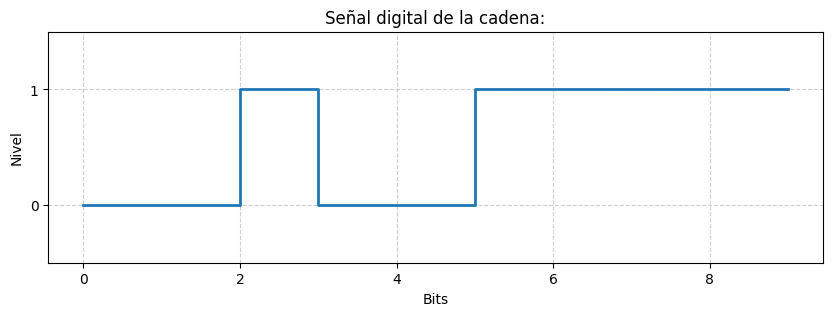

In [366]:
# Crear decodificación de bits sabiendo que:
#        '00': (-1, -1), -> -I, -Q
#        '01': (-1, 1), -> -I, +Q
#        '10': (1, -1), -> +I, -Q
#        '11': (1, 1) -> +I, +Q
decodificacion = {
    (-1, -1): '00',
    (-1, 1): '01',
    (1, -1): '10',
    (1, 1): '11'
}
# Decodificar los bits a partir de las integrales
bits_decodificados = ''
for i in range(len(integral_I)):
    I = 1 if integral_I[i] > 0 else -1
    Q = 1 if integral_Q[i] > 0 else -1
    bits_decodificados += decodificacion[(I, Q)]
print("Bits Decodificados:", bits_decodificados[:len(bits_decodificados)-1])
print("Bits Originales:   ", bits[:len(bits)-1])
# verificar si los bits decodificados coinciden con los originales
error_count = 0
for i in range(min(len(bits), len(bits_decodificados))):
    if bits[i] != bits_decodificados[i]:
        print(f"Error en el bit {i}: original={bits[i]}, decodificado={bits_decodificados[i]}")
        error_count += 1
if error_count == 0:
    print("Todos los bits decodificados coinciden con los originales.")
else:
    print(f"Total de bits con error: {error_count} de {min(len(bits), len(bits_decodificados))}")

# Graficar bits decodificados
t_decod, señal_decod = graficar_bits(bits_decodificados)



# Decodificar en Huffman

In [367]:
# Decodificar en Huffman
print(bits_decodificados[:len(bits)-3])
# Ignorar los bits adicionales agregados
mensaje_decodificado = huffman_decode(bits_decodificados[:len(bits)-3], codes)
print("Mensaje Decodificado:", mensaje_decodificado)


0010011


ValueError: Bits sobrantes: el flujo de bits no coincide con los códigos.